In [1]:
import numpy as np
import gym
import os
import random
import time
from progressbar import ProgressBar
from time import sleep
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from matplotlib import image
from progressbar import ProgressBar

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras import optimizers
from keras import backend as K

from utils import pre_process_frame

# init env
env_name = 'Breakout-v0'
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.env.action_space.n

/Users/rharriso/miniconda2/envs/sonic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/rharriso/Desktop/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [2]:
def create_network(action_size, alpha, initializer='glorot_uniform'):
    optimizer = optimizers.RMSprop(lr=alpha, clipvalue=0.5)
    
    net = Sequential([
        Conv2D(
            32,
            (8, 8),
            strides=(4,4),
            input_shape=(84, 84, 4),
            activation='relu',
            kernel_initializer=initializer,
            data_format="channels_last"
        ),
        Conv2D(
            64,
            (4,4),
            strides=(2,2),
            activation='relu',
            kernel_initializer=initializer
        ),
        Conv2D(
            64,
            (3,3),
            strides=(1,1),
            activation='relu',
            kernel_initializer=initializer
        ),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer=initializer),
        Dense(action_size, activation='linear', kernel_initializer=initializer)
    ])
    net.compile(loss='mse', optimizer=optimizer)
    return net

In [3]:
alpha = 0.00025
gamma=0.99
training_frame_count = 5e7 # 50 million frames
greedy_end = 1e6 # 1 million exploration frames
action_update_interval = 4
q_update_interval = 16
qhat_update_interval = 500
sample_size=32 # how many samples do we take each time
min_replay_size = 500 # whhen does training start (replay mem size)
max_replay_size = 25000 # what is the max replay memory
chart_interval = 1e3 # every 10k frames show me a chart

# step increment at begining of loop
step = 0

# trainy boi
training_started = False
frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
prime_frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
action_memory = np.zeros((max_replay_size, 1), dtype='int')
reward_memory = np.zeros((max_replay_size, 1), dtype='float')
done_memory = np.zeros((max_replay_size, 1), dtype='bool')

replay_index = -1

# stats
training_rewards = []
rewards = []
mean_rewards = []
mean_training_rewards = []
epsilons = []
training_loss = []
training_step = []
training_score = []
test_score = []
last_episode = 0

# init networks
q_net = create_network(action_size, alpha)
q_hat_net = create_network(action_size, alpha, 'zeros')

pbar = ProgressBar()


# SVG(model_to_dot(q_net).create(prog='dot', format='svg'))

N/A% (0 of 50000000.0) |                 | Elapsed Time: 0:00:00 ETA:  --:--:--

update_weights


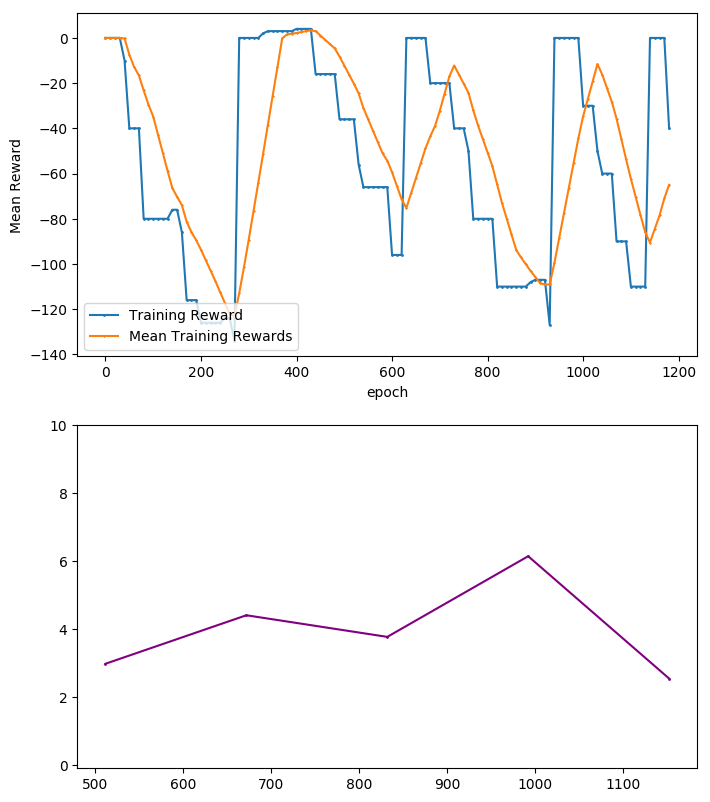

  0% (16 of 50000000.0) |       | Elapsed Time: 0:00:01 ETA:  51 days, 16:03:52

update_weights


  0% (31 of 50000000.0) |        | Elapsed Time: 0:00:02 ETA:  48 days, 1:48:30

update_weights


  0% (45 of 50000000.0) |        | Elapsed Time: 0:00:03 ETA:  30 days, 6:41:03

update_weights


  0% (65 of 50000000.0) |       | Elapsed Time: 0:00:04 ETA:  29 days, 14:52:46

update_weights


  0% (80 of 50000000.0) |       | Elapsed Time: 0:00:04 ETA:  23 days, 20:06:27

update_weights


  0% (95 of 50000000.0) |        | Elapsed Time: 0:00:05 ETA:  24 days, 9:27:19

update_weights


100% (50000000.0 of 50000000.0) |########| Elapsed Time: 0:00:05 Time:  0:00:05


KeyboardInterrupt: 

In [5]:

def time_usage(func):
    def wrapper(*args, **kwargs):
        beg_ts = time.time()
        retval = func(*args, **kwargs)
        end_ts = time.time()
        # print("elapsed time %s: %f" % (func.__name__, end_ts - beg_ts))
        return retval
    return wrapper

def run_episode(frame_index, render=True):
    if frame_index < greedy_end:
        epsilon = 1. - (frame_index / greedy_end) * 0.9
    else:
        epsilon = 0.1
    
    moves = 0
    beg_ts = time.time()
    done = False
    frame = env.reset()
    old_lives = -1
    prev_frame = np.zeros_like(frame) # the "prevvious" frame is nothing
    phi_frame = pre_process_frame(frame, prev_frame)

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            phi_shape = phi_frame.shape
            shaped_frame = phi_frame.reshape(1, phi_shape[0], phi_shape[1], phi_shape[2])
            action = np.argmax(q_net.predict(shaped_frame))

        reward = 0
        
        for i in range(action_update_interval):
            prime_frame, _reward, done, ale_lives = env.step(action)
            reward += _reward
            lives = ale_lives['ale.lives']
            
            if lives < old_lives:
                reward -= 10
            old_lives = lives
            
            done = done or lives == 0

            if render:
                env.render()

            phi_prime_frame = pre_process_frame(frame, prime_frame)

            yield phi_frame, action, reward, phi_prime_frame, done, lives

            phi_frame = phi_prime_frame
            prev_frame = frame
            frame = prime_frame
            moves += 1


weight_updates = 0

# @time_usage
def update_weights():
    # crop memory
    global frame_memory, action_memory, reward_memory, prime_frame_memory, done_memory, weight_updates, replay_index

    memory_sample = random.sample(
        range(0, min(replay_index, max_replay_size)),
        sample_size
    )

    _frame_batch = frame_memory[memory_sample]
    _prime_frame_batch = prime_frame_memory[memory_sample]
    _action_batch = action_memory[memory_sample]
    _reward_batch = reward_memory[memory_sample]
    _done_batch = done_memory[memory_sample]

    _predictions = q_net.predict(_frame_batch)
    _corrections = _predictions.copy()
    _prime_predictions = q_hat_net.predict(_prime_frame_batch)

    for i in range(0, sample_size):
        _done = _done_batch[i]
        _reward = _reward_batch[i]
        _action = _action_batch[i]

        _prime_prediction = _prime_predictions[i]
        if _done:
            _corrections[i, _action] = _reward_batch[i]
        else:
            _corrections[i, _action] = _reward + gamma * np.max(_prime_prediction)
    loss = q_net.train_on_batch(_frame_batch, _corrections)
    
    if weight_updates % qhat_update_interval == 0:
        q_hat_net.set_weights(q_net.get_weights())
    weight_updates += 1
    return loss

step = -1
training_started = False
with ProgressBar(max_value=training_frame_count) as bar:
    bar.update(0)
    while step < training_frame_count:
        training_score = 0
        # for every action in the episode
        for (
            frame,
            action,
            reward,
            prime_frame,
            done,
            lives
        ) in run_episode(step, render=True):
            step += 1
            bar.update(step)
            #
            replay_index += 1
            replay_array_index = replay_index % max_replay_size
            frame_memory[replay_array_index] = frame
            prime_frame_memory[replay_array_index] = prime_frame
            action_memory[replay_array_index] = action
            reward_memory[replay_array_index] = reward
            done_memory[replay_array_index] = done

            training_score += reward

            # if time do the training
            if step % q_update_interval == 0 and min_replay_size < replay_index:
                if not training_started:
                    training_started = True
                    # print("Training Started: ", step)
                loss = update_weights()
                training_loss.append(loss)
                training_step.append(step)


            # print("Record metrics")
            training_rewards.append(training_score)
            mean_training_rewards.append(np.mean(training_rewards[-100:]))

            # display progress
            if step % chart_interval == 0:
                index_step = 10
                episodes_num = np.arange(0, len(mean_training_rewards))[0::index_step]
                _mean_training_rewards = mean_training_rewards[0::index_step]
                #         _mean_rewards = mean_rewards[0::index_step]
                #         _rewards = rewards[0::index_step]
                _training_rewards = training_rewards[0::index_step]
                _epsilons = epsilons[0::index_step]
                episode_index = len(mean_training_rewards)


                fig = plt.figure(figsize=(8, 10), dpi=100)
                plt.subplot(211)
                plt.plot(episodes_num, _training_rewards, marker='o', markersize=1, label='Training Reward')
                #         par1.plot(episodes_num, _rewards, marker='o', markersize=5, label='Test Reward')
                plt.plot(episodes_num, _mean_training_rewards, marker='x', markersize=1, label='Mean Training Rewards')
                #         par1.plot(episodes_num, _mean_rewards, marker='o', markersize=5, label='Mean Test Reward')
                plt.legend(loc='lower left')
                plt.xlabel('epoch')
                plt.ylabel('Mean Reward')

                plt.subplot(212)
                plt.plot(training_step[0::index_step], training_loss[0::index_step], marker='o', markersize=1, label='Training Loss', color='purple')
                plt.ylim(-0.1, 10)

                plt.pause(0.01)

                # save after charting
                model_file = '%s-%s-%s-pool-actions.weights' % (env_name, alpha, step)
                q_net.save_weights(model_file)


In [1]:
model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
net.save_weights(model_file)
print(model_file)

NameError: name 'env_name' is not defined